In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import EA_funcs as ea
import matplotlib.pyplot as plt

# Introduction

This notebook aims to generate multiple portfolios created for different sets of assets (that is, different search spaces).
The idea is to see how these compare to the ETF VMEX benchmark (~21% returns with a risk of 18.1%), and get an idea of what we could consider from our proposed method to be a success.

The porfolios here are all created randomly following the scheme described below, but only the best for each set of assets will be tested. 

## Portfolio generating mechanism:
See `random_search()` in the `algorithms.py` file for the source code.

Chromosomes of an adequate length are randomly generated and normalized so that all its elements (genes) sum to 1. Each gene represents the weight of the investment for its respective asset. Then follows a check for the constraints on maximum risk and maximum weight per asset. If these constraintsa are satisfied, the chromosome is added to the population, otherwise a new chromosome is generated. This process is repeated until the specified population size is reached. 

After the chromosomes are generated, the expected return can be obtained by performing its dot product with the vector of anual expected returns for the assets corresponding to the covariance matrix used to compute the risk during population creation.

The next sections explore the returns and risks obtained by this method for different sets of assets.

In [2]:
np.random.seed(14)

## Totally random search

Here we generate portfolios out of the whole search space, where all 402 assets are available. By default, in each random search 100,000 portfolios are created.

We can see that, although the best portfolio has expected returns of 18.6% on the training tada, when tested on a dynamic setting the actual profit was only 4.75%. This portfolio, therefore, was not robust enough, and failed in practice to approach the VMEX benchmark of ~21%.

mean training returns: 11.115%
mean training risk: 11.839%
best training returns in population: 18.592%
with risk: 14.357%


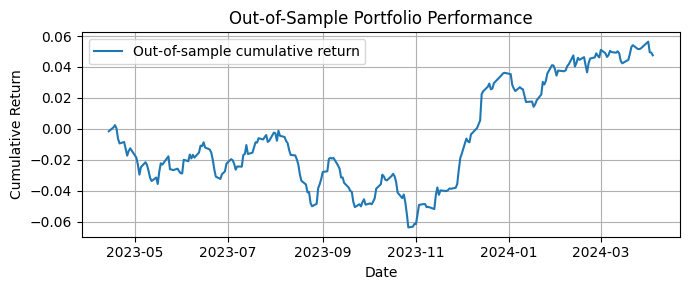

Actual return was 4.75% with a volatility of 6.27%


In [3]:
ea.test_random(ea.all_data)

## Semi-random search

Now we randomly select a given number of national and international assets, as well as some FIBRAS, and ensure that BONDDIA, CETES and ENERFIN are included in the search space. This reduces the search space's dimension from 402 to 40, while keeping diversity in the type of assets available for the portfolio. The numbers 15, 16, and 6 are somewhat proportional to the number of assets in each category, but truly they were mostly arbitrary.

In [4]:
random_ticks = np.random.choice(ea.tickers_NC, 15)
random_ticks = np.append(random_ticks, np.random.choice(ea.tickers_IC, 16))
random_ticks = np.append(random_ticks, np.random.choice(ea.tickers_F, 6))
random_ticks = np.append(random_ticks, ea.tickers_BONDDIA)
random_ticks = np.append(random_ticks, ea.tickers_CETES)
random_ticks = np.append(random_ticks, ea.tickers_ENERFIN)

random_ticks.shape

closing_prices_random = ea.all_data[random_ticks]

This asset selection was an improvement compared to using the whole search space not only in performance but also in speed. However, the test returns of 9.5% are still too low compared to the VMEX benchmark.

mean training returns: 3.2%
mean training risk: 10.998%
best training returns in population: 11.14%
with risk: 9.557%


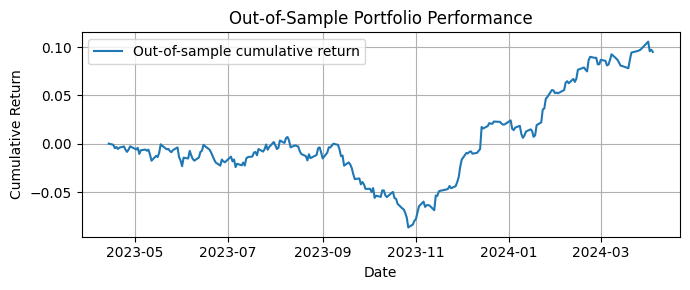

Actual return was 9.5% with a volatility of 7.59%


In [5]:
ea.test_random(closing_prices_random)

## Semi-deterministic search

Now we make a ranking of the "best" assets in each category, according to the following criteria:

$$
\text{worth}_i = \frac{\text{anual returns}_i}{\text{risk}_i},
$$

where the higher worth implies a higher ranking of asset $i$.

For consistency, we keep the same number of assets from each category as in the previous section.

In [6]:
print("National")
national, national_top = ea.returns_to_risk_ratio(ea.tickers_NC, 15, display=True)

print("\nInternational")
international, international_top = ea.returns_to_risk_ratio(ea.tickers_IC, 16, display=True)

print("\nFIBRAS")
fibras, fibras_top = ea.returns_to_risk_ratio(ea.tickers_F, 6, display=True)

bonddia, _ = ea.returns_to_risk_ratio(ea.tickers_BONDDIA, 1)
cetes, _ = ea.returns_to_risk_ratio(ea.tickers_CETES, 1)
enerfin, _ = ea.returns_to_risk_ratio(ea.tickers_ENERFIN, 1)

National
               return/risk  anual return
CHDRAUIB.MX      30.533351      0.502305
LAMOSA.MX        29.922172      0.418857
VISTAA.MX        27.913815      0.914456
BAFARB.MX        24.591972      0.387490
GPROFUT.MX       23.814817      0.294088
PSOTRAC15.MX     22.536592      0.166068
BBAJIOO.MX       22.288682      0.418751
FRAGUAB.MX       20.984662      0.356001
ALSEA.MX         20.428416      0.382220
AC.MX            19.126087      0.256323
LIVEPOL1.MX      18.766512      0.263872
GENTERA.MX       18.669513      0.428172
LIVEPOLC-1.MX    18.606501      0.282443
CIEB.MX          18.532940      0.549310
CMOCTEZ.MX       17.235585      0.150320

International
          return/risk  anual return
LLY.MX      24.500471      0.465206
NVDA.MX     20.369435      0.649226
DELLC.MX    18.615024      0.532571
STLD.MX     17.773125      0.425833
ORLY.MX     17.257585      0.247057
XLE.MX      16.726604      0.317184
COP.MX      16.105865      0.379874
XOM.MX      15.578893      0.324

From the printed tables we can see the expected anual returns are, in general, not too highly correlated to the inherent - weighted - quality of the asset. The following proves this idea, since the correlation between anual return and return/risk is not too large:

In [7]:
temp = pd.concat([national_top, international_top, fibras_top])
temp.corr()

,return/risk,anual return
return/risk,1.000000,0.571599
anual return,0.571599,1.000000


And we can see it more intuitively in the following scatterplot where, although there is some kind of trend, its so lose that we could hardly consider anual returns in of themselves as any kind of guideline. 

This result reinforces the observation that asset risks have to be taken into account (in case that wasn't obvious).

<Axes: xlabel='anual return', ylabel='return/risk'>

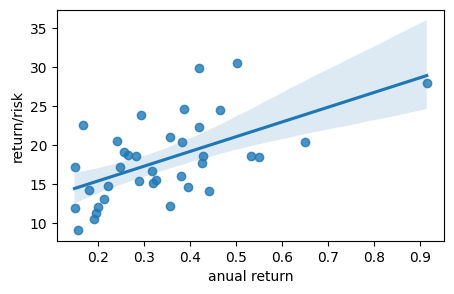

In [8]:
plt.figure(figsize=(5, 3))
sns.regplot(pd.concat([national_top, international_top, fibras_top]), 
                x="anual return", y="return/risk")

Back to the main issue, we now filter the closing prices for the ones corresponding to our top-ranked assets:

In [9]:
top_ticks = np.concatenate([national, international, 
                                 fibras, bonddia, cetes, enerfin])

top_prices = ea.all_data[top_ticks]

And perform the same random portfolio population. In this case we find that the test returns (28.73%) are way higher than the ~21% of the VMEX benchmark, with a very small volatility (6.84%). 

mean training returns: 33.149%
mean training risk: 8.951%
best training returns in population: 40.902%
with risk: 10.085%


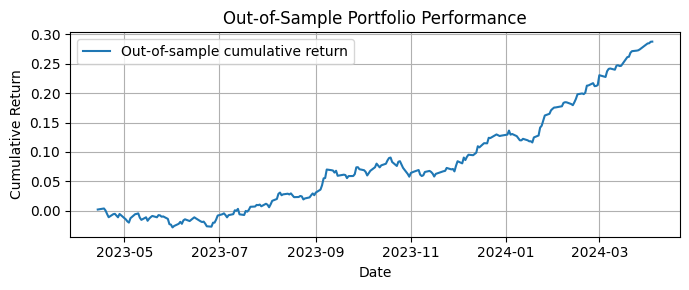

Actual return was 28.73% with a volatility of 6.84%


In [10]:
ea.test_random(top_prices)

## Benchmark: ETF (VMEX)

Let's see how the actual benchmark's asset set does on this same timeframe.

In [11]:
start = '2021-01-01'
end = '2024-04-05'

benchmark = pd.read_csv("../data/benchmark.csv")
ticks = benchmark["Tickers"].to_list()

benchmark_closing_prices = ea.get_historical_data(ticks, start, end)

benchmark_daily_returns= benchmark_closing_prices.pct_change().dropna()

benchmark_cov_matrix = benchmark_daily_returns.cov()

e:\documents\ming\intro to evolutionary computation\proyecto final\EA_funcs\utils.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  42 of 43 completed

1 Failed download:
['AGUILASCPO.MX']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-01-01 -> 2024-04-05) (Yahoo error = "Data doesn\'t exist for startDate = 1609480800, endDate = 1712296800")')
[*********************100%***********************]  42 of 43 completed

Unfortunately, the benchmark didn't do too well in this case:

mean training returns: 17.058%
mean training risk: 13.454%
best training returns in population: 23.903%
with risk: 13.668%


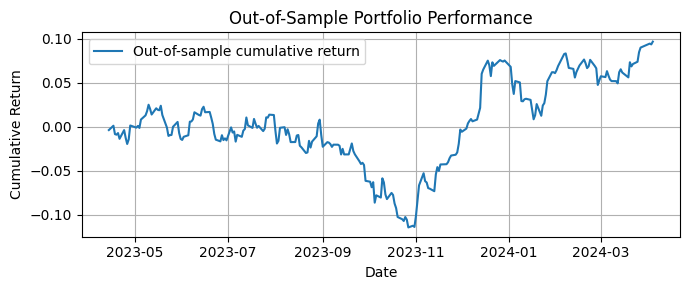

Actual return was 9.65% with a volatility of 13.7%


In [12]:
ea.test_random(benchmark_closing_prices)

Due to this result, we'll use the metrics from the previous section as a new benchmark:

# New Benchmark

The benchmark to defeat with the evolutionary algorithm is the following:

- Returns of 28.73% during the testing period.
- Risk of 18%, as in the VMEX ETF, since any improvement in returns that mantains or improves the risk of the original benchmark is already an improvement.